# Treinamento regressão

In [1]:
treinar = {
    'GP': False,
    'RegressaoLinear': True,
    'BayesianLinearRegression': True,
    'BayesianPolinomialLinearRegression': True,
    'BayesianLinearRegressionNew': True,
    'BayesianPolinomialLinearRegressionNew': True,
    'BayesianRBFLinearRegression': True,
}

In [2]:
# Métrica utilizada na otimização bayesiana para seleção do modelo
metrica = 'nlpd'

In [3]:
bo_max_iter=50

In [4]:
#nome_dataset_treino = 'housesToRentProcessed_train_full.csv'  # Completo
nome_dataset_treino = 'dataset_without_anomaly.csv'  # Sem anomalia

nome_dataset_teste = 'housesToRentProcessed_test_full.csv'  # Completo
nome_dataset_teste_sem_anomalia = 'dataset_test_without_anomaly.csv'  # Sem anomalia

## Conjunto de dados

In [5]:
import numpy as np
import pandas as pd

dataset_train = pd.read_csv(nome_dataset_treino, index_col=0)
dataset_test = pd.read_csv(nome_dataset_teste, index_col=0)
dataset_test_sem_anomalia = pd.read_csv(nome_dataset_teste_sem_anomalia, index_col=0)

colunas_X = [
    'São Paulo', 'Porto Alegre', 'Rio de Janeiro', 'Campinas', 'Belo Horizonte', 
    'area',
    'rooms', 'bathroom', 'parking spaces', 'floor', 'isHouse', 'animal', 'furniture',
]
coluna_y = ['y con + alu']


X_train = dataset_train[colunas_X].values
y_train = dataset_train[coluna_y].values

X_test = dataset_test[colunas_X].values
y_test = dataset_test[coluna_y].values

X_test_sem_anomalia = dataset_test_sem_anomalia[colunas_X].values
y_test_sem_anomalia = dataset_test_sem_anomalia[coluna_y].values

### Descrição do conjunto de dados

| Atributo         | Descrição                                           | Tipo     | Codificação  |
| ---------------- | --------------------------------------------------- | -------- | ------------------------- |
| `São Paulo`      | Imóvel está localizado na cidade de São Paulo?      | Booleano | `int: 0 false, - 1 true` |
| `Porto Alegre`   | Imóvel está localizado na cidade de Porto Alegre?   | Booleano | `int: 0 false, - 1 true` |
| `Rio de Janeiro` | Imóvel está localizado na cidade de Rio de Janeiro? | Booleano | `int: 0 false, - 1 true` |
| `Campinas`       | Imóvel está localizado na cidade de Campinas?       | Booleano | `int: 0 false, - 1 true` |
| `Belo Horizonte` | Imóvel está localizado na cidade de Belo Horizonte? | Booleano | `int: 0 false, - 1 true` |
| `area`           | Área do imóvel (em metros quadrados)                | $\mathbb{R}^*_{+}$  (reais positivos não nulo) | `float` |
| `rooms`          | Quantidade de quartos                               | $\mathbb{N}$ |`int` |
| `bathroom`       | Quantidade de banheiros                             | $\mathbb{N}$ |`int` |
| `floor`          | Andar localizado o imóvel                           | $\mathbb{N}$ |`int` |
| `isHouse`        | Imóvel corresponde a um aluguel de casa             | Booleano | `int: 0 false, - 1 true` |
| `animal`         | É possivel levar animais para o imóvel              | Booleano | `int: 0 false, - 1 true` |
| `furniture`      | Se a casa já vem mobiliada                          | Booleano | `int: 0 false, - 1 true` |
| `y con + alu`    | Valor mensal total do aluguel do imóvel: aluguel + taxa de condomínio. | $\mathbb{R}^*_{+}$  (reais positivos não nulo) | `float` |

In [6]:
dataset_train.head()

,São Paulo,Porto Alegre,Rio de Janeiro,Campinas,Belo Horizonte,area,rooms,bathroom,parking spaces,floor,isHouse,animal,furniture,y con + alu
index,,,,,,,,,,,,,,
4294,0,0,0,0,1,20,1,1,0,1,0,0,0,500
5152,1,0,0,0,0,35,1,1,0,1,1,0,0,500
8183,0,1,0,0,0,30,1,1,0,1,1,0,0,500
10218,0,0,0,0,1,25,1,1,1,1,0,0,0,500
9317,0,0,1,0,0,30,1,1,1,3,0,1,0,500


### Separação de treino e teste

Os dados foram separados em treino e em teste seguindo a proporção de $70\%$ para treino e de $30\%$ para testes. O processo de seleção do modelo será descrito posteriormente.

**Obs:** O processo de separação foi feito em outro notebook

In [7]:
# from sklearn.model_selection import train_test_split

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print('Quantidade de elementos para o treinamento:', X_train.shape)
print('Quantidade de elementos selecionados para teste:', X_test.shape)

Quantidade de elementos para o treinamento: (7259, 13)
Quantidade de elementos selecionados para teste: (3208, 13)


### Normalização - AJEITAR

A normalização aplicada no conjunto de dados foi a [standard scaling](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html):
\begin{aligned}
z = \frac{x_i - \mu_i}{\sigma_i}; \\
\mu_i = \frac{1}{N} \sum_{i=1}^N x_i; \\
\sigma_i = \sqrt{\frac{1}{N} \sum_{i=1}^N (x_i - \mu_i)^2}.
%A transformação aplicada, escala (dimensiona) e translada cada característica individualmente, de modo que esta esteja entre o intervalo $[0, 1]$.
\end{aligned}

Como poderá ser visto adiante, este trabalho tomou o cuidado dos dados de validação e de teste serem transformados conforme os dados  a escala definida no treinamento.

In [8]:
from sklearn.preprocessing import StandardScaler

Scaler = StandardScaler

## Treinamento

Para cada um dos modelos avaliados, houve uma seleção dos hiperparâmetros por meio de uma Otimização Bayesiana (BO).
Em cada iteração da Otimização Bayesiana, era aplicada uma validação cruzada de _5-folds_.
A métrica definida para a busca dos melhores hiperparâmetros via BO foi a média do NLPD da validação cruzada. A métrica NLPD é descrita adiante neste trabalho.

Além da média do NLPD, os modelos foram avaliados por outras métricas, descritas a seguir.

### Métricas

#### Root Mean Squared Error (RMSE)

__Root Mean Squared Error__ ou raiz do erro quadrático médio [_terminar_]

\begin{aligned}
\text{MSE}(\boldsymbol{y}, \hat{\boldsymbol{y}}) &= \frac{1}{N_\text{teste}} \sum_{i=1}^{N_\text{teste}} (y_i - \hat{y}_i)^2; \\
\text{RMSE}(\boldsymbol{y}, \hat{\boldsymbol{y}}) &= \sqrt{\text{MSE}(\boldsymbol{y}, \hat{\boldsymbol{y}})}.
\end{aligned}

In [9]:
from trabalho.util.metrica import rmse

#### Negative Log Predictive Density (NLPD)

A métrica **Negative Log Predictive Density** (NLPD) leva em consideração a variância predita $\hat{\sigma}_i^2$, além dos valores esperados e preditos (média):

\begin{aligned}
\text{NLPD}
&= -\frac{1}{N_\text{teste}}
    \sum_{i=1}^{N_\text{teste}}
    \log 
    \overbrace{p(y_i|\boldsymbol{x}_i, \boldsymbol{y}, \boldsymbol{X}, \hat{\boldsymbol{\theta}})}^{\mathcal{N}(y_i|\hat{\mu}_i, \hat{\sigma}_i^2)}
    \\
&= \frac{1}{2}\log2\pi + \frac{1}{2 N_\text{teste}}
\sum_{i=1}^{N_\text{teste}} \left[\log \hat{\sigma}^2_i + \frac{(y_i - \hat{\mu}_i)^2}{\hat{\sigma}^2_i}\right]
\end{aligned}

Conforme já discutido em aula, a NLPD busca realçar modelos equilibrandos, penalizando:
* modelos muito confiantes nos casos de erros grandes ($\sigma^2_i$ baixos para erros maiores), e;
* modelos pouco confiantes nos casos de erros pequenos ($\sigma^2_i$ altos para erros menores).

In [10]:
from trabalho.util.metrica import nlpd

#### Mean absolute percentage error (MAPE)

A métrica **Mean Absolute Percentage Error** (MAPE),
também conhecida como **Mean absolute percentage deviation** (MAPD),
**FIXME**

\begin{aligned}
\text{MAPE}(y, \hat{y}) = \frac{1}{n_{\text{samples}}} \sum_{i=0}^{n_{\text{samples}}-1} \frac{{}\left| y_i - \hat{y}_i \right|}{max(\epsilon, \left| y_i \right|)}
\end{aligned}
onde $\epsilon$ é um número arbitrário pequeno o suficiente para evitar resultados não definidos quando $y = 0$.

FALAR SOBRE, referências
* https://scikit-learn.org/dev/modules/model_evaluation.html#mean-absolute-percentage-error 
* https://towardsdatascience.com/choosing-the-correct-error-metric-mape-vs-smape-5328dec53fac

In [11]:
from trabalho.util.metrica import mape

## Modelos utilizados

In [12]:
relatorio_modelos = pd.DataFrame(columns=['modelo', 'parametros', 'rmse', 'nlpd', 'mape', 'fold'])

### Processos Gaussianos

In [13]:
from trabalho.modelos.gp import GP

GP

trabalho.modelos.gp.GP

#### Hiperparâmetros a serem procurados

In [14]:
from trabalho.util.otimizacao_bayesiana import Dominio
import gpflow


kernels = [
    gpflow.kernels.Matern12(),
    gpflow.kernels.Matern32(),
    gpflow.kernels.Matern52(),
    
    gpflow.kernels.SquaredExponential(),
]


means = [
    # Padrão
    gpflow.mean_functions.Zero(),
    # Média
    gpflow.mean_functions.Linear(),
]

dominio_gp = Dominio([
    # https://gpflow.readthedocs.io/en/master/gpflow/kernels/#gpflow-kernels-linear
    {
        'name': 'kernel',
        'type': 'categorical',
        'domain': kernels
    },
    {
        'name': 'mean_function',
        'type': 'categorical',
        'domain': means
    },
#     {'name': 'learning_rate',   'type': 'continuous', 'domain': (0.0001, 0.02)},
#     {'name': 'sampling_method', 'type': 'discrete',   'domain': (1, 3, 5)},
#     {'name': 'regularization',  'type': 'continuous', 'domain': (0.00001, 0.01)},
#     {'name': 'batch_size',      'type': 'discrete',   'domain': (10, 16, 32)},
])

dominio_gp.dominio

[{'name': 'kernel', 'type': 'categorical', 'domain': [0, 1, 2, 3]},
 {'name': 'mean_function', 'type': 'categorical', 'domain': [0, 1]}]

### Regressão Linear

#### Regressão Linear (não bayesiana)

In [15]:
from trabalho.modelos.regressao_linear import RegressaoLinear

RegressaoLinear

trabalho.modelos.regressao_linear.RegressaoLinear

##### Hiperparâmetros a serem procurados

In [16]:
dominio_regressao_linear = Dominio([])

#### Regressão Linear Bayesiana

In [17]:
from trabalho.modelos.bayesian_linear_regression import BayesianLinearRegression

BayesianLinearRegression

trabalho.modelos.bayesian_linear_regression.BayesianLinearRegression

In [18]:
from trabalho.modelos.bayesian_linear_regression_new import BayesianLinearRegressionNew

BayesianLinearRegressionNew

trabalho.modelos.bayesian_linear_regression_new.BayesianLinearRegressionNew

##### Hiperparâmetros a serem procurados

In [19]:
dominio_regressao_linear_bayesiana = Dominio([
    {
        'name': 'alphaInit',
        'type': 'continuous',
        'domain': (1e-7, 1.1)
    },
    {
        'name': 'lambdaInit',
        'type': 'continuous',
        'domain': (1e-7, 1.1)
    }
])

In [20]:
dominio_regressao_linear_bayesiana_new = Dominio([
    {
        'name': 'sig2_error',
        'type': 'continuous',
        'domain': (1e-5, 0.1)
    }
])

#### Regressão Linear Bayesiana Polinomial

In [21]:
from trabalho.modelos.bayesian_polinomial_linear_regression import BayesianPolinomialLinearRegression

BayesianPolinomialLinearRegression

trabalho.modelos.bayesian_polinomial_linear_regression.BayesianPolinomialLinearRegression

In [22]:
from trabalho.modelos.bayesian_polinomial_linear_regression_new import BayesianPolinomialLinearRegressionNew

BayesianPolinomialLinearRegressionNew

trabalho.modelos.bayesian_polinomial_linear_regression_new.BayesianPolinomialLinearRegressionNew

##### Hiperparâmetros a serem procurados

In [23]:
dominio_regressao_linear_bayesiana_polinomial = Dominio([
    {
        'name': 'alphaInit',
        'type': 'continuous',
        'domain': (0.0001, 1.1)
    },
    {
        'name': 'lambdaInit',
        'type': 'continuous',
        'domain': (0.0001, 1.1)
    },
    {
        'name': 'order',
        'type': 'discrete',
        'domain': (2, 3, 4, 5, 6, 7, 8, 9, 10)
    }
])

In [24]:
dominio_regressao_linear_bayesiana_polinomial_new = Dominio([
    {
        'name': 'sig2_error',
        'type': 'continuous',
        'domain': (1e-5, 0.1)
    },
    # Poderia ser por model evidence, mas vamos deixar assim mesmo
    {
        'name': 'order',
        'type': 'discrete',
        'domain': (2, 3, 4, 5, 6, 7, 8, 9, 10)
    }
])

#### Regressão Linear Bayesiana com kernel RBF

In [25]:
from trabalho.modelos.bayesian_rbf_linear_regression import BayesianRBFLinearRegression

BayesianRBFLinearRegression

trabalho.modelos.bayesian_rbf_linear_regression.BayesianRBFLinearRegression

##### Hiperparâmetros a serem procurados

In [26]:
dominio_regressao_linear_bayesiana_rbf = Dominio([
#     {
#         'name': 'm0',
#         'type': 'continuous',
#         'domain': (0.0001, 1.1)
#     },
#     {
#         'name': 'S0',
#         'type': 'continuous',
#         'domain': (0.0001, 1.1)
#     },
    {
        'name': 'sig2_error',
        'type': 'continuous',
        'domain': (1e-5, 1)
    },
    {
        'name': 'mean_rbf_arbitrario',
        'type': 'continuous',
        'domain': (-1, 1)
    },
    {
        'name': 'lambda_rbf_arbitrario',
        'type': 'continuous',
        'domain': (1e-7, 1)
    }
])

### Validação - Seleção de modelos

In [27]:
from trabalho.util.kfold import KFoldCrossValidation
from GPyOpt.methods import BayesianOptimization
from tqdm import tqdm


def f(Modelo, X, y, metrica, k_folds, relatorio_geral, **kwargs):
    relatorio_parcial = pd.DataFrame(columns=['modelo', 'parametros', 'rmse', 'nlpd', 'mape', 'fold', 'tentativa'])
    
    for fold, X_train, X_validation, y_train, y_validation in tqdm(KFoldCrossValidation(X, y, k_folds).split(), total=k_folds, desc="k-fold"):
        resultado = treinar_modelo(Modelo, X_train, X_validation, y_train, y_validation, **kwargs)
        
        total_execucoes = len(relatorio_geral)
        tentativa = (total_execucoes - total_execucoes % k_folds) / k_folds
        
        relatorio_parcial.loc[len(relatorio_parcial)] = resultado + [fold, tentativa]
        relatorio_geral.loc[total_execucoes] = resultado + [fold, tentativa]


    medias = relatorio_parcial.mean()
    
    # Fixme: juntar com o relatório final
    #relatorio_parcial
    
    return medias[metrica]


def treinar_modelo(Modelo, X_train, X_validation, y_train, y_validation, **kwargs):
    X_scaler = Scaler()
    y_scaler = Scaler()

    X_train_transform      = X_scaler.fit_transform(X_train)
    X_validation_transform = X_scaler.transform(X_validation)
    y_train_transform      = y_scaler.fit_transform(y_train)
    y_validation_transform = y_scaler.transform(y_validation)

    modelo = Modelo(**kwargs)
    modelo.fit(X_train_transform, y_train_transform)

    means, vars = modelo.predict(X_validation_transform)
    means = means.reshape((-1, 1))
    vars = vars.reshape((-1, 1))

    means_dimensao_correta = y_scaler.inverse_transform(means)
    std_errors_modelo = np.sqrt(vars)
    std_errors_scaler = np.sqrt(y_scaler.var_)
    
    vars_dimensao_correta = (std_errors_modelo * std_errors_scaler)**2

    erro_rmse = rmse(means_dimensao_correta, y_validation)
    erro_nlpd = nlpd(means_dimensao_correta, vars_dimensao_correta, y_validation)
    erro_mape = mape(means_dimensao_correta, y_validation)
    
    
    return [Modelo.__name__, kwargs, erro_rmse, erro_nlpd, erro_mape]


def otimizacao_bayesiana(Modelo, dominio, X, y, k_folds=5, metrica='nlpd', max_iter=50):
    relatorio = pd.DataFrame(columns=['modelo', 'parametros', 'rmse', 'nlpd', 'mape', 'fold', 'tentativa'])
    funcao = dominio.gerar_f(Modelo=Modelo, f=f, X=X, y=y, k_folds=5, metrica=metrica, relatorio_geral=relatorio)

    bo = BayesianOptimization(f=funcao, domain=dominio.dominio, verbosity=True)
    bo.run_optimization(max_iter=max_iter)

    try:
        bo.plot_convergence()
        bo.plot_acquisition()
    except Exception as e:
        print(e)

    print(f'{metrica}:', bo.fx_opt)
    print('Parâmetros:', bo.x_opt)

    return relatorio

In [28]:
modelos = {
    'GP': (GP, dominio_gp),
    'RegressaoLinear': (RegressaoLinear, dominio_regressao_linear),
    'BayesianLinearRegression': (BayesianLinearRegression, dominio_regressao_linear_bayesiana),
    'BayesianPolinomialLinearRegression': (BayesianPolinomialLinearRegression, dominio_regressao_linear_bayesiana_polinomial),
    'BayesianLinearRegressionNew': (BayesianLinearRegressionNew, dominio_regressao_linear_bayesiana_new),
    'BayesianPolinomialLinearRegressionNew': (BayesianPolinomialLinearRegressionNew, dominio_regressao_linear_bayesiana_polinomial_new),
    'BayesianRBFLinearRegression': (BayesianRBFLinearRegression, dominio_regressao_linear_bayesiana_rbf),
}

k-fold:   0%|          | 0/5 [00:00<?, ?it/s]

GP False
RegressaoLinear True


k-fold: 100%|██████████| 5/5 [00:00<00:00, 37.69it/s]


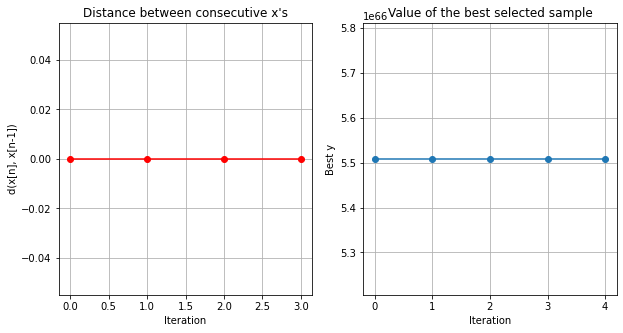

k-fold:  40%|████      | 2/5 [00:00<00:00, 18.70it/s]

not enough values to unpack (expected 2, got 0)
nlpd: 5.508639771557694e+66
Parâmetros: []
BayesianLinearRegression True


k-fold: 100%|██████████| 5/5 [00:00<00:00, 12.53it/s]


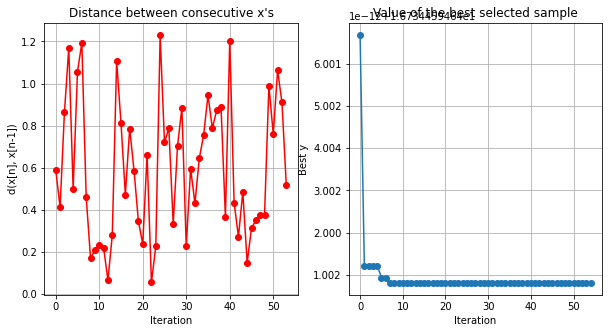

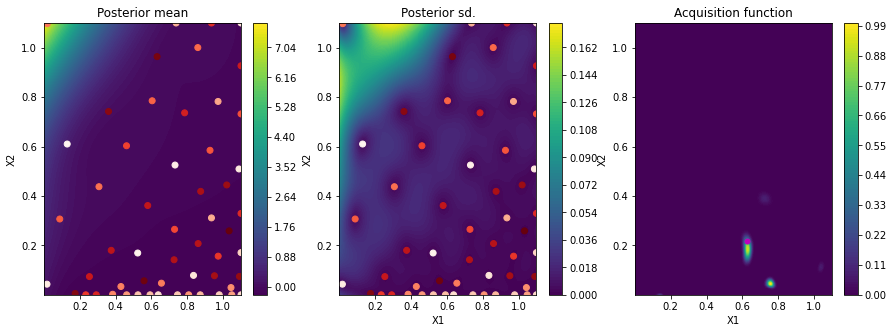

k-fold:   0%|          | 0/5 [00:00<?, ?it/s]

nlpd: 16.734459463610822
Parâmetros: [6.37517717e-01 1.00000000e-07]
BayesianPolinomialLinearRegression True


k-fold: 100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


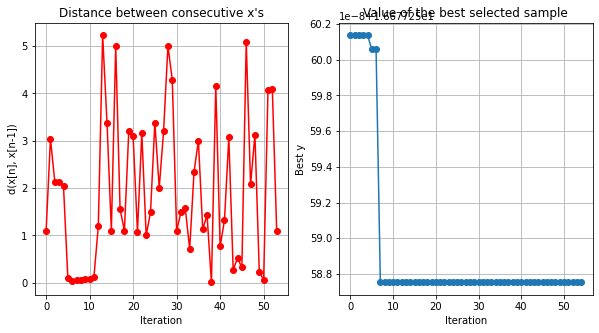

k-fold:  40%|████      | 2/5 [00:00<00:00, 16.39it/s]

nlpd: 16.677250587526995
Parâmetros: [0.00587459 0.0637858  4.        ]
BayesianLinearRegressionNew True


k-fold: 100%|██████████| 5/5 [00:00<00:00, 19.85it/s]


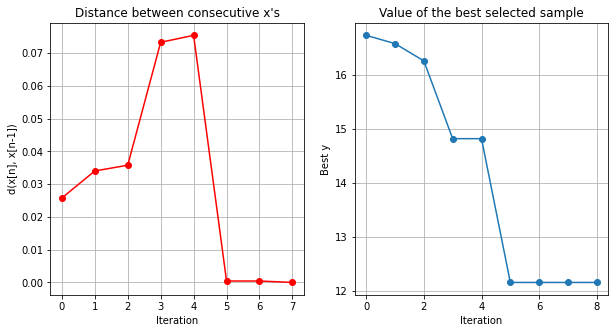

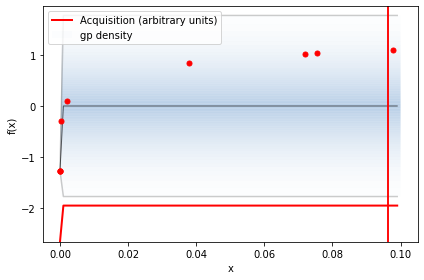

k-fold:   0%|          | 0/5 [00:00<?, ?it/s]

nlpd: 12.155169822215466
Parâmetros: [1.e-05]
BayesianPolinomialLinearRegressionNew True


k-fold: 100%|██████████| 5/5 [00:03<00:00,  1.30it/s]


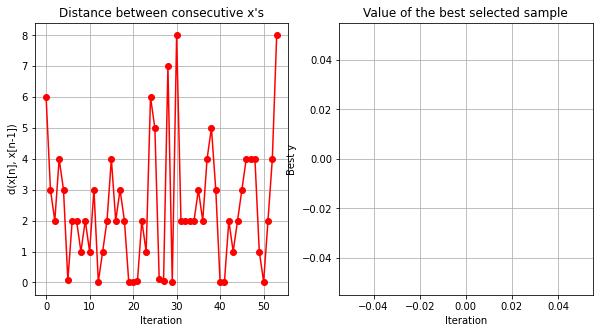

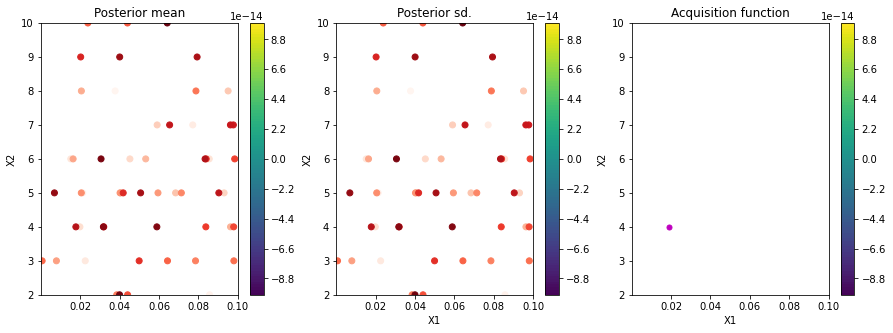

k-fold:   0%|          | 0/5 [00:00<?, ?it/s]

nlpd: nan
Parâmetros: [0.0377323 8.       ]
BayesianRBFLinearRegression True


k-fold: 100%|██████████| 5/5 [00:02<00:00,  2.32it/s]


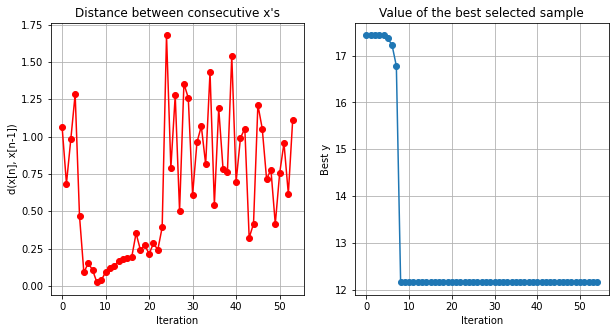

nlpd: 12.154601111009626
Parâmetros: [1.00000000e-05 5.06195039e-01 1.00000000e+00]


In [29]:
relatorio_modelos = pd.DataFrame(columns=['modelo', 'parametros', 'rmse', 'nlpd', 'mape', 'fold', 'tentativa'])


for modelo, (Classe, dominio) in modelos.items():
    print(modelo, treinar[modelo])
    if treinar[modelo]:
        resultado_parcial = otimizacao_bayesiana(Modelo=Classe, dominio=dominio, X=X_train, y=y_train, metrica=metrica, max_iter=bo_max_iter)
        relatorio_modelos = pd.concat([relatorio_modelos, resultado_parcial])
        resultado_parcial.to_csv(f'resultados/parciais/{modelo}_{metrica}.csv')

#### Resultado prelimiar

In [30]:
relatorio_condensado = \
relatorio_modelos.groupby(['modelo', 'tentativa']) \
                  .agg(['mean', 'std']) \
                  .reset_index() \
                  .sort_values(by=(metrica, 'mean')) \
                  .groupby('modelo').first()

relatorio_condensado

tentativa         rmse               \
                                                        mean          std   
modelo                                                                      
BayesianLinearRegression                    7.0  2688.911572  2178.217636   
BayesianLinearRegressionNew                 8.0  2688.697004  2176.500569   
BayesianPolinomialLinearRegression          7.0  2745.815592  2226.759621   
BayesianPolinomialLinearRegressionNew      27.0  2725.290756  2203.585484   
BayesianRBFLinearRegression                30.0  3823.433923  2053.615286   
RegressaoLinear                             0.0  2689.319110  2175.098350   

                                               nlpd                    mape  \
                                               mean           std      mean   
modelo                                                                        
BayesianLinearRegression               1.673446e+01  8.261836e-01  1.206484   
BayesianLinearRegressionNew            1.215517e+01  8.156530e-01  0.662921   
BayesianPolinomialLinearRegression     1.667725e+01  8.291505e-01  1.577675   
BayesianPolinomialLinearRegressionNew  1.424737e+01  8.510501e-01  1.005421   
BayesianRBFLinearRegression            1.215460e+01  8.078928e-01  1.069023   
RegressaoLinear                        5.508640e+66  8.583215e+66  0.633075   

                                                 
                                            std  
modelo                                           
BayesianLinearRegression               1.573512  
BayesianLinearRegressionNew            0.453812  
BayesianPolinomialLinearRegression     2.345819  
BayesianPolinomialLinearRegressionNew  0.780328  
BayesianRBFLinearRegression            0.485753  
RegressaoLinear                        0.409580

### Resultado Final

In [31]:
melhores_hiperparametros = {}

for modelo, tentativa in relatorio_condensado[['tentativa']].reset_index().values:
    resultado = (relatorio_modelos.modelo == modelo) & (relatorio_modelos.tentativa == tentativa)
    melhores_hiperparametros[modelo] = relatorio_modelos[resultado].parametros.values[0]

pd.DataFrame(melhores_hiperparametros)

,BayesianLinearRegression,BayesianLinearRegressionNew,BayesianPolinomialLinearRegression,BayesianPolinomialLinearRegressionNew,BayesianRBFLinearRegression,RegressaoLinear
alphaInit,6.375177e-01,NaN,0.005875,NaN,NaN,NaN
lambdaInit,1.000000e-07,NaN,0.063786,NaN,NaN,NaN
sig2_error,NaN,0.00001,NaN,0.000671,0.000010,NaN
order,NaN,NaN,4.000000,3.000000,NaN,NaN
mean_rbf_arbitrario,NaN,NaN,NaN,NaN,0.506195,NaN
lambda_rbf_arbitrario,NaN,NaN,NaN,NaN,1.000000,NaN


In [32]:
relatorio_final = pd.DataFrame(columns=['modelo', 'parametros', 'rmse', 'nlpd', 'mape'])


for i, (modelo, hiperparametros) in tqdm(enumerate(melhores_hiperparametros.items())):
    Modelo, dominio = modelos[modelo]
    resultado = treinar_modelo(Modelo, X_train, X_test, y_train, y_test, **hiperparametros)
                                         
    relatorio_final.loc[i] = resultado
    

# # Nome do arquivo
# nomes_modelos = relatorio.modelo.unique()
# nomes_modelos.sort()

# nome_arquivo = f'resultados/final/{fold_externo}_{metrica}_{"-".join(nomes_modelos)}.csv'
# relatorio.to_csv(nome_arquivo)
relatorio_final

6it [00:01,  4.16it/s]


,modelo,parametros,rmse,nlpd,mape
0,BayesianLinearRegression,"{'alphaInit': 0.6375177174749428, 'lambdaInit'...",20237.068037,1.697965e+01,0.535715
1,BayesianLinearRegressionNew,{'sig2_error': 1e-05},20236.797972,1.241098e+01,0.529435
2,BayesianPolinomialLinearRegression,"{'alphaInit': 0.005874594306081417, 'lambdaIni...",20205.109178,1.693379e+01,0.687810
3,BayesianPolinomialLinearRegressionNew,"{'sig2_error': 0.000671060563682353, 'order': ...",20200.236453,1.449207e+01,0.585839
4,BayesianRBFLinearRegression,"{'sig2_error': 1e-05, 'mean_rbf_arbitrario': 0...",20380.679410,1.241384e+01,1.074137
5,RegressaoLinear,{},20236.781599,2.047637e+68,0.530646


In [34]:
print('Com rejeição')
relatorio_final = pd.DataFrame(columns=['modelo', 'parametros', 'rmse', 'nlpd', 'mape'])

for i, (modelo, hiperparametros) in tqdm(enumerate(melhores_hiperparametros.items())):
    Modelo, dominio = modelos[modelo]
    resultado = treinar_modelo(Modelo, X_train, X_test_sem_anomalia, y_train, y_test_sem_anomalia, **hiperparametros)
                                         
    relatorio_final.loc[i] = resultado
    

# # Nome do arquivo
# nomes_modelos = relatorio.modelo.unique()
# nomes_modelos.sort()

# nome_arquivo = f'resultados/final/{fold_externo}_{metrica}_{"-".join(nomes_modelos)}.csv'
# relatorio.to_csv(nome_arquivo)
relatorio_final

0it [00:00, ?it/s]

Com rejeição


6it [00:00,  6.09it/s]


,modelo,parametros,rmse,nlpd,mape
0,BayesianLinearRegression,"{'alphaInit': 0.6375177174749428, 'lambdaInit'...",2552.545665,1.697958e+01,0.465938
1,BayesianLinearRegressionNew,{'sig2_error': 1e-05},2552.502733,1.238954e+01,0.459691
2,BayesianPolinomialLinearRegression,"{'alphaInit': 0.005874594306081417, 'lambdaIni...",2471.462753,1.693087e+01,0.631237
3,BayesianPolinomialLinearRegressionNew,"{'sig2_error': 0.000671060563682353, 'order': ...",2472.027234,1.449038e+01,0.527028
4,BayesianRBFLinearRegression,"{'sig2_error': 1e-05, 'mean_rbf_arbitrario': 0...",3311.434825,1.239194e+01,0.968831
5,RegressaoLinear,{},2552.460128,3.257526e+66,0.460938
